#Data Story Project "London Underground data"

***

##Description and data sources

The current project aims to provide useful insights on usage of London tube and help Londoners to plan their journeys.
The project uses two data sets:

   ** 1. Oyster card data**
   
    This dataset provides a 5% sample of all Oyster card journeys performed in a week during November 2009 on bus, Tube, DLR and London Overground.
    
   ** 2. London Underground passenger counts data**
    
    Passenger counts collects information about passenger numbers entering and exiting London Underground stations, largely based on the Underground ticketing system gate data.
    
**Data source: "Transport for London" (https://api-portal.tfl.gov.uk/)**

***

##Loading modules

In [2]:
import pandas as pd
import numpy as np
import os
import folium

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14, 'font.family': 'serif'})

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

***

##Loading data

In [3]:
data_folder = 'C:\\data_science_intensive\\Data_story_project\\London Underground data'
os.chdir(data_folder)

***

### Importing Oyster card data

In [4]:
file_oyster = 'Nov09JnyExport.csv'
data_oyster = pd.read_csv(file_oyster)
len(data_oyster) #the data set contains 2623487 data entries

2623487

**Column descriptions**

- downo - a number between 1 and 7, 1 being Sunday, 2 being Monday etc
- daytype - Sun to Sat
- SubSystem - the mode(s) of the journey. LUL - London Underground, NR - National Rail, LTB - London Buses, DLR- Docklands Light - Railway, LRC - London Overground, TRAM - Croydon Tram
- StartStn - Station the journey started at
- EndStation - Station the journey ended at
- EntTime - Entry time of the journey in minutes after midnight
- EntTimeHHMM - Entry time in HH:MM text format
- ExTime - Exit time of the journey in minutes after midnight
- EXTimeHHMM - Exit time in HH:MM text format
- ZVPPT - zones of Oyster Season ticket, if used
- JNYTYP - Product types involved in the journey. PPY - Pure PAYG, TKT - Pure Oyster Season, MIXED - Combined PAYG and Oyster  Season
- DailyCapping - it shows as Y when PAYG journey was capped
- FFare - Full PAYG Fare before any discounts
- Dfare - PAYG Fare after usage based discounts
- RouteID - The Route Number of the Bus, if a Bus has been boarded
- FinalProduct - Combined Product Description used for journey

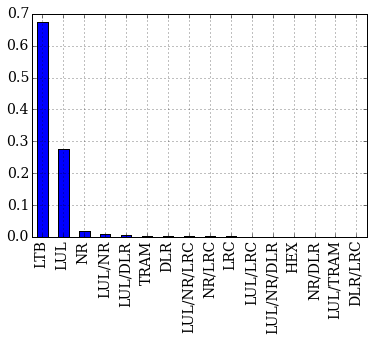

In [5]:
df_subsystems = (data_oyster.SubSystem).value_counts()/len(data_oyster)
df_subsystems.plot(kind = 'bar')

The majority of data entries are related to trips by London Buses (67%) and London Tube (28%)

In [6]:
#Bus
data_oyster_bus = data_oyster[data_oyster.SubSystem == 'LTB']
# Removing irrelevant columns (for example, there is no information on exit time of the journey if a Bus was used)
data_oyster_bus.drop(['StartStn','EndStation', 'ExTime', 'EXTimeHHMM', 'FFare', 'DFare'], axis=1, inplace=True)

In [7]:
#Tube
data_oyster_tube = data_oyster[data_oyster.SubSystem == 'LUL']

In [8]:
data_oyster_tube.StartStn.unique() #StartStn column contains 'Unstarted' values (20283 rows in total)
len(data_oyster_tube[data_oyster_tube.StartStn == 'Unstarted'])
data_oyster_tube = data_oyster_tube[data_oyster_tube.StartStn != 'Unstarted'] #removing rows that have no information of start stations

In [9]:
data_oyster_tube.EndStation.unique()
len(data_oyster_tube[data_oyster_tube.EndStation == 'Not Applicable']) #EndStation column contains 'Not Applicable' values (1 row)
data_oyster_tube = data_oyster_tube[(data_oyster_tube.EndStation != 'Not Applicable') & (data_oyster_tube.EndStation !='Unfinished')] #removing rows that have no information of end stations

***

### Importing London Underground passenger counts data

In [10]:
file_count_weekday = 'En 12Week.xls'
file_count_sat = 'En12sat.xls'
file_count_sun = 'En12sun.xls'

In [11]:
def read_xls_count_data(filename, Sheetname, ncolsskip):
    df = pd.read_excel(filename, Sheetname, skiprows = 6,skip_footer =2)
    df.drop(df.columns[-ncolsskip:], axis=1, inplace=True)
    df.drop(['nlc', 'Date', 'Note'], axis=1, inplace=True)
    df = df.set_index('Station')
    del df.index.name
    df['Total'] = df.sum(axis =1)
    return df

In [12]:
data_counts_week = read_xls_count_data(file_count_weekday, 'En Wk 12',7)
data_counts_sat = read_xls_count_data(file_count_sat, 'En SAT 2012',2)
data_counts_sun = read_xls_count_data(file_count_sun, 'En SUN 2012',2)

***

##Busiest stations 

###London Underground passenger counts data

What are the busiest stations? (Bar plots; weekdays, Saturdays and Sundays separetly)

In [127]:
def plottopN(dfs, N, title, width = 0.25,color = 'black'):
    
    
    df = pd.DataFrame(dfs.order(ascending = False).head(N)) # selecting top N from the data Frame
    
    ind = np.arange(N)  # the x locations for the groups
    
    rects1 = plt.barh(ind, df['Total']/1000, width, alpha = 0.5, color=color)

    plt.yticks(ind+0.5*width)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.tick_right()
    plt.title(title, fontweight = 'bold', fontsize = 20)
    plt.grid()
    plt.xlim([0,140])
    ytickNames = plt.gca().set_yticklabels(df['Total'].index)
    plt.setp(ytickNames, rotation=0, fontsize=14, fontweight = 'bold')
    

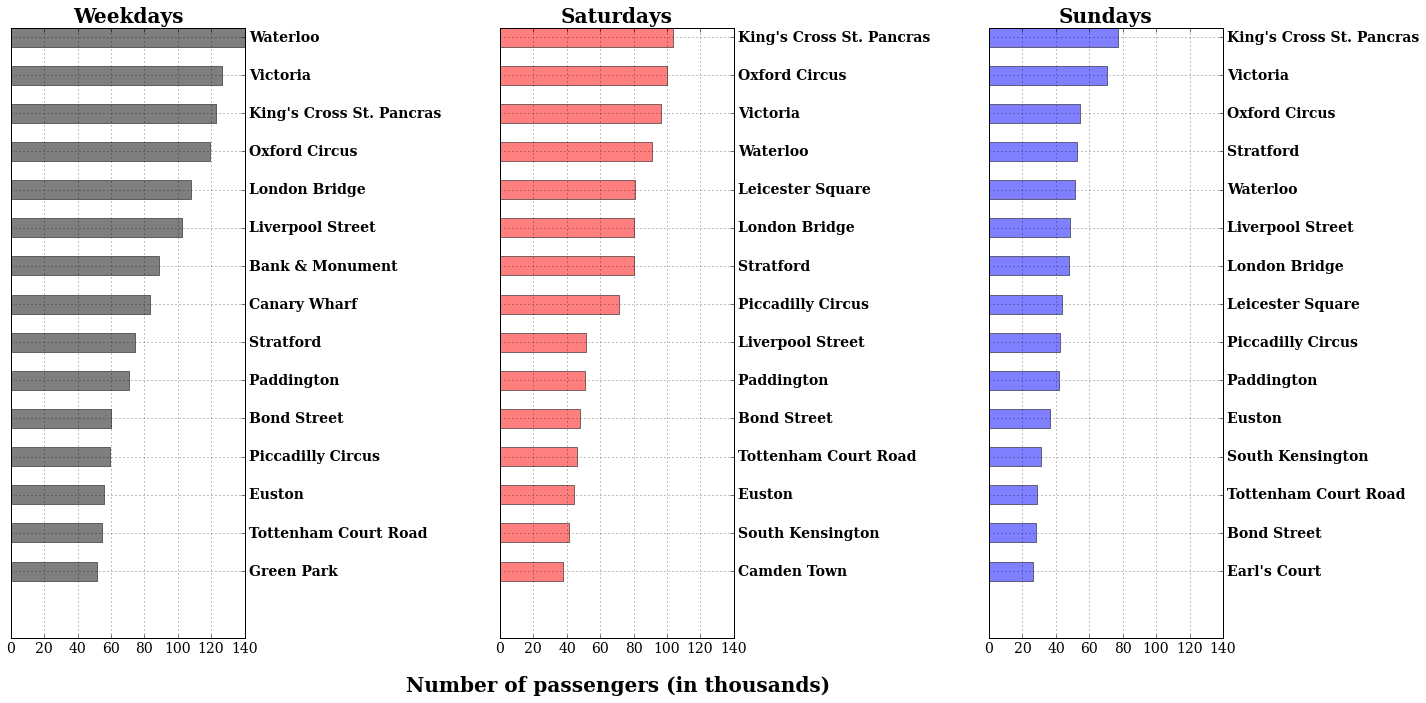

In [141]:
fig = plt.figure(figsize = (20,10))


N = 15 ## How many most busi
                
#plt.suptitle('London Underground passenger counts data', fontweight = 'bold', fontsize = 20) OVERLAPS!!
plt.subplot(131)
plottopN(data_counts_week['Total'], N, 'Weekdays', width = 0.5,color = 'black')

plt.subplot(132)
plottopN(data_counts_sat['Total'], N, 'Saturdays', width = 0.5,color = 'red')
plt.xlabel('Number of passengers (in thousands)', fontweight = 'bold', fontsize = 20, labelpad=20)

plt.subplot(133)
plottopN(data_counts_sun['Total'], N, 'Sundays', width = 0.5,color = 'blue')

plt.tight_layout()


What are the busiest stations? (Bar plots; weekdays, Saturdays and Sundays stucked)

In [175]:
N = 20 #How many stations I want to consider?

In [428]:
data_counts = pd.concat([data_counts_week['Total'], data_counts_sat['Total'], data_counts_sun['Total']], axis = 1)
data_counts.columns = ['Week', 'Saturday','Sunday']
data_counts['All_together'] = data_counts.sum(axis = 1)
data_counts_top10 = data_counts.sort(['All_together'], ascending=0).head(N)

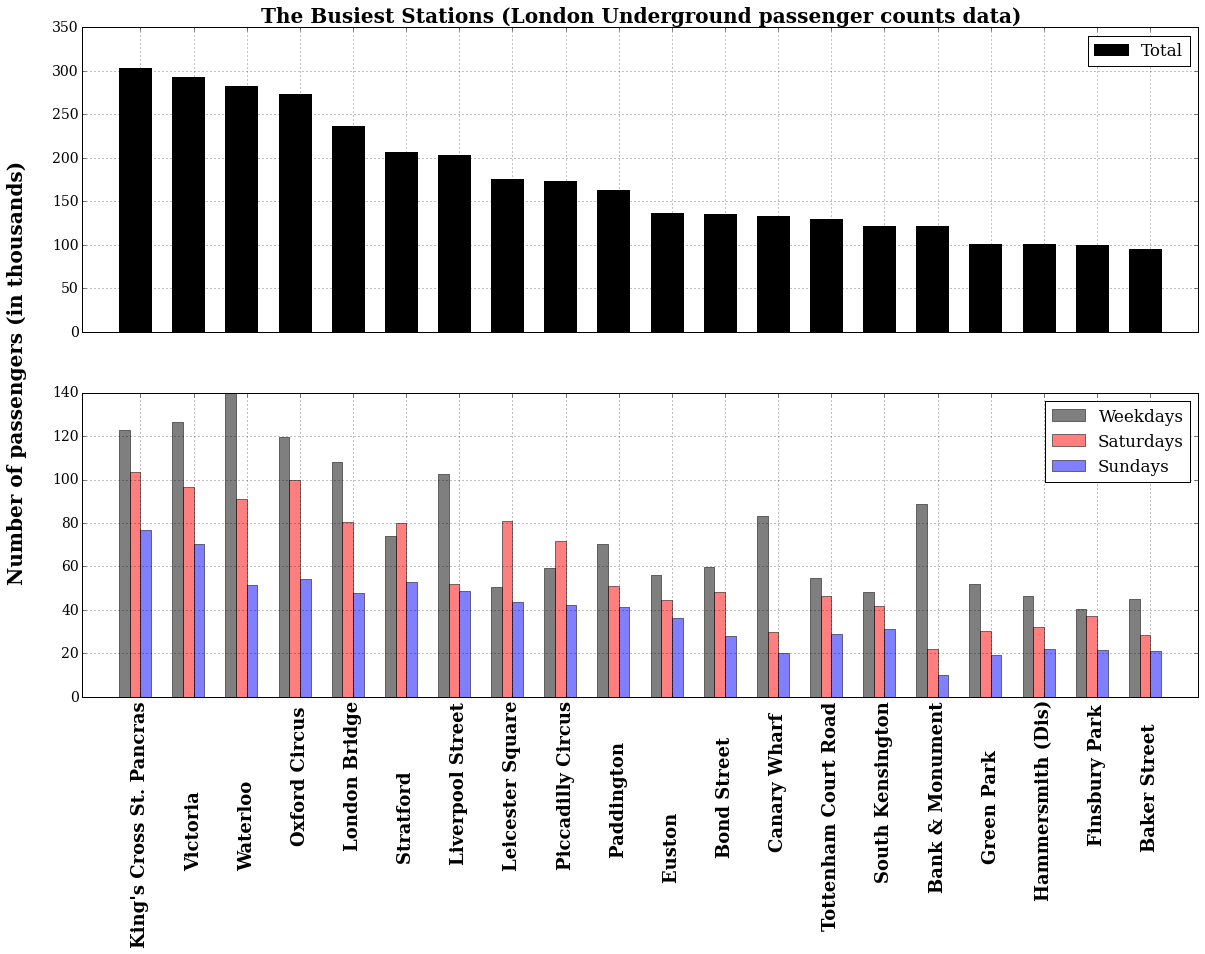

In [202]:
ind = np.arange(N)
width = 0.2

fig = plt.figure(figsize = (20,12))
ax0 = plt.subplot(211)
ax0.bar(ind, data_counts_top10['All_together']/1000,width*3,color='k',align='center', label = 'Total')
ax0.set_xlim([-1,N])
ax0.xaxis.set_major_formatter(plt.NullFormatter())
plt.grid()
plt.xticks(ind+0.5*width)
plt.legend(loc = 'best')
plt.title('The Busiest Stations (London Underground passenger counts data)', fontweight = 'bold', fontsize = 20)

ax = plt.subplot(212)
ax.bar(ind-width, data_counts_top10['Week']/1000,width, alpha = 0.5, color='k',align='center', label = 'Weekdays')
ax.bar(ind, data_counts_top10['Saturday']/1000,width,alpha = 0.5,color='r',align='center', label = 'Saturdays')
ax.bar(ind+width, data_counts_top10['Sunday']/1000,width, alpha = 0.5,color='b',align='center',label = 'Sundays')
plt.legend(loc = 'best')
plt.grid()
plt.xticks(ind+0.5*width)
plt.xlim([-1,N])
xtickNames = plt.gca().set_xticklabels(data_counts_top10.index, fontweight = 'bold', fontsize = 18, rotation = 90)

fig.text(0.08, 0.5, 'Number of passengers (in thousands)', fontweight = 'bold', fontsize = 20, ha='center', va='center', rotation='vertical')

When are the busiest stations so busy? (Time series plot)

In [339]:
#Subsetting the data frames (only leave the busiest stations)
n_bs = 10 # Consider only top 10 for time series plot
global busy_stations
mask = []
for a in data_counts_week.index:
    if a in busy_stations:
        mask.append(True)
    else:
        mask.append(False)
               

In [374]:
def modify_df_for_TS_plot(DF, mask):
    DF = DF.drop('Total', 1)
    DF = DF[mask].reindex(busy_stations)
    return DF.transpose()

In [392]:
c=np.random.rand(3,n_bs)

In [404]:
def timeseries_plot(df, c, n_bs):
    ind = np.arange(len(df.index))
    df.index = [datetime.strptime(t[0:4], '%H%M') for t in df.index]
    df = df.sort_index()
    for i in np.arange(n_bs):
        if i <4:
            line = 4
        else:
            line = 2
        plt.plot(x, df[df.columns[i]], color = c[:,i], linewidth = line, label =df.columns[i] )
    plt.grid()
    plt.ylabel('Number of passengers', fontweight = 'bold', fontsize = 14)

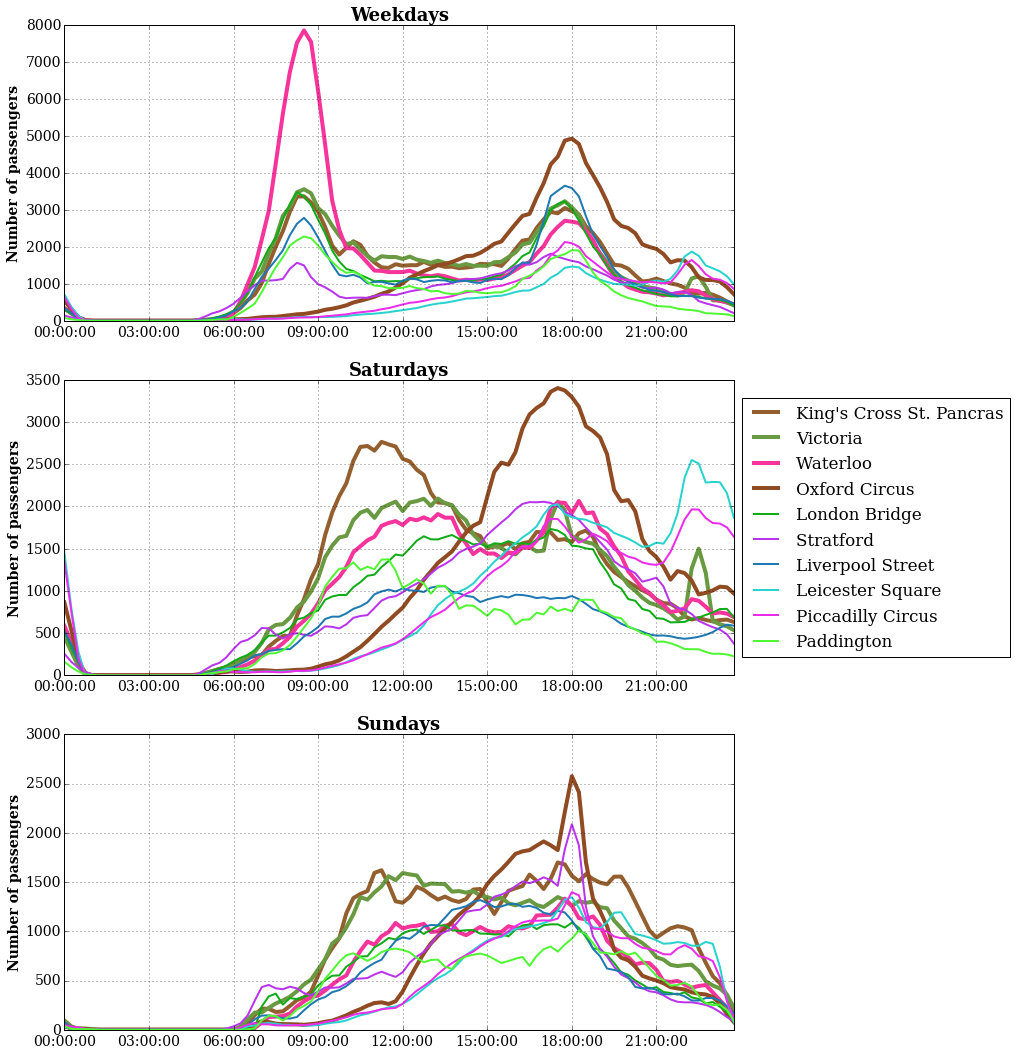

In [410]:
plt.figure(figsize = (12,18))

###Time series plot for week days
plt.subplot(311)
timeseries_plot(modify_df_for_TS_plot(data_counts_week, mask), c,n_bs)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Weekdays', fontweight = 'bold', fontsize = 18)

###Time series plot for Saturdays
plt.subplot(312)
timeseries_plot(modify_df_for_TS_plot(data_counts_sat, mask), c,n_bs)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Saturdays', fontweight = 'bold', fontsize = 18)

###Time series plot for Sundays
plt.subplot(313)
timeseries_plot(modify_df_for_TS_plot(data_counts_sun, mask), c,n_bs)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Sundays', fontweight = 'bold', fontsize = 18)

 - During Weekdays passenger distribution is kind of bimodel for a number of stations, mainly railway stations (e.g. Waterloo, Victoria, Liverpool Street). People come to work in London from other places in UK. 
 - A singal peak around 6pm can be observed for Oxford street station for Weekdays, Saturdays and Sundays. Potentially can be explained by people going shopping.
 - Leicester Square station is busy on Saturday night. Londoners are going out to pubs/bars/restraunts in that area. 


------

##Oyster card data

What is the mean travel time by London Underground?

In [435]:
data_oyster_tube['travel_time'] = data_oyster_tube['ExTime'] - data_oyster_tube['EntTime']

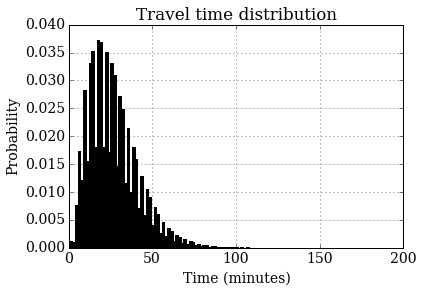

In [444]:
n, bins, patches = plt.hist(np.array(data_oyster_tube['travel_time']),bins = 100, color = 'black', normed = 1)
plt.grid(True)
plt.xlim([0,200])
plt.ylabel('Probability')
plt.xlabel('Time (minutes)')
plt.title('Travel time distribution')

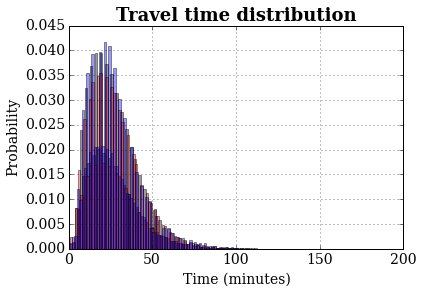

In [450]:
n, bins, patches = plt.hist(np.array(data_oyster_tube[(data_oyster_tube['daytype'] != 'Sat') 
                                            & (data_oyster_tube['daytype'] != 'Sun')]['travel_time']),
                            bins = 100, color = 'k', normed = 1, alpha = 0.4, label = 'Weekdays')
n, bins, patches = plt.hist(np.array(data_oyster_tube[data_oyster_tube['daytype'] == 'Sat']['travel_time']),
                            bins = 100, color = 'r', normed = 1, alpha = 0.4)
n, bins, patches = plt.hist(np.array(data_oyster_tube[data_oyster_tube['daytype'] == 'Sun']['travel_time']),
                            bins = 100, color = 'b', normed = 1, alpha = 0.4)


plt.grid(True)
plt.xlim([0,200])
plt.ylabel('Probability')
plt.xlabel('Time (minutes)')
plt.title('Travel time distribution', fontweight = 'bold', fontsize = 18)

What are the most popular routes in London Underground?

In [422]:
data_oyster_tube['Route'] = data_oyster_tube['StartStn'] + ' to ' + data_oyster_tube['EndStation']

In [426]:
#The most popular routes on Weekdays
data_oyster_tube[(data_oyster_tube['daytype'] != 'Sat') & (data_oyster_tube['daytype'] != 'Sun')]['Route'].value_counts().head(5)

Canary Wharf to Waterloo JLE     980
Waterloo JLE to Canary Wharf     969
Oxford Circus to Victoria        927
Victoria to Oxford Circus        925
Canary Wharf to London Bridge    867
dtype: int64

In [423]:
#The most popular routes on Saturdays
data_oyster_tube[data_oyster_tube['daytype'] == 'Sat']['Route'].value_counts().head(5)

London Bridge to Angel               91
Oxford Circus to Waterloo            90
London Bridge to Kings Cross T       80
Leicester Square to Waterloo         76
Liverpool Street to Oxford Circus    72
dtype: int64

In [424]:
#The most popular routes on Sundays
data_oyster_tube[data_oyster_tube['daytype'] == 'Sun']['Route'].value_counts().head(5)

Kings Cross T to Victoria                 89
Kings Cross T to London Bridge            72
London Bridge to Waterloo JLE             71
Waterloo JLE to London Bridge             62
Shepherd's Bush Und to Ealing Broadway    52
dtype: int64

How are the most popular routes in London Underground change over a day?

In [430]:
data_oyster_tube_sub = data_oyster_tube[['EntTime', 'ExTime','Route','daytype']]

In [431]:
data_oyster_tube_sub[]

,EntTime,ExTime,Route,daytype
45989,1000,1041,Goodge Street to Totteridge,Mon
45994,1000,1024,Preston Road to Northwood,Thu
45998,1000,1028,Holborn to Bounds Green,Thu
46003,1000,1021,Earls Court to Pimlico,Sun
46005,1000,1027,Victoria to Bethnal Green,Tue
46019,1000,1020,Highbury to Stratford,Mon
46025,1000,1026,Embankment to Putney Bridge,Sat
46029,1000,1031,Monument to Tufnell Park,Wed
46031,1000,1006,South Kensington to Victoria,Thu
46033,1000,1009,St James's Park to Temple,Wed
